# Event-related Analysis

This example shows how to use Neurokit to extract epochs from data based on events localisation and its corresponding physiological signals.

## Understanding the Data

In this example, we will download the data, which contains 2.5 minutes of data recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points). 


In [1]:
# Load the NeuroKit package and related dependencies
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns

# Get data
data = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit/master/data/example_bio_100hz.csv")

This experiment consisted of 4 events (when the photosensor signal goes down), which were 2 types of images that were shown to the participant: "Negative" in emotionality vs "Neutral" in emotionality. Each picture was presented for 3 seconds. The following list is the condition order.

In [17]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

## Find Events

The data was obtained using 4 channels, namely the EDA, ECG, RSP and the Photosensor. We should find the onsets of events that are within our photosensor's signal, which can be localized and extracted using [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find). Note that you should also specify the `threshold_keep` to select events that are higher or below the threshold.

In [18]:
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

As we can see, `events_find()` returns a dict containing onsets and durations for each corresponding event, based on the label for event identifiers and each event condition. Each event here lasts for 300 data points (equivalent to 3 seconds sampled at 100Hz).

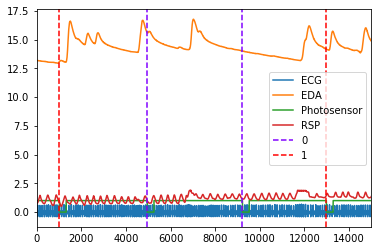

In [19]:
# Plot events
plot = nk.events_plot(events, data)

The output of [events_plot()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_plot) shows the corresponding events in the signal, with the blue dashed line representing a Negative event and red dashed line representing a Neutral event.

## Process the Signals

Biosignals processing can be done quite easily using NeuroKit with the `bio_process()` function. Simply provide the appropriate biosignal channels and additional channels that you want to keep (for example, the photosensor), and `bio_process()` will take care of the rest. It will return a dict containing dataframes of all the relevant signals and their features.

In [20]:
# Process the signal
bio = nk.bio_process(ecg=data["ECG"], rsp=data["RSP"], eda=data["EDA"], emg=None, keep=data["Photosensor"], sampling_rate=100)

# Visualize the first three rows of each dataframe in the dictionary of processed bio signals
for keys,values in bio.items():
    print(keys[:3])
    print(values[:3])

ECG
    ECG_Raw  ECG_Clean   ECG_Rate  ECG_R_Peaks
0 -0.015869   0.001499  61.261503          0.0
1 -0.011703   0.005177  61.261492          0.0
2 -0.009766   0.006632  61.261456          0.0
RSP
    RSP_Raw  RSP_Clean   RSP_Rate  RSP_Amplitude
0  0.778931  -0.141309  16.843014       0.730062
1  0.777588  -0.141298  16.840038       0.730631
2  0.777435  -0.141304  16.837064       0.731200
EDA
     EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  SCR_Onsets  SCR_Peaks  \
0  13.196868  13.196849  13.102238    0.094612         0.0        0.0   
1  13.197173  13.195557  13.101986    0.093571         0.0        0.0   
2  13.197020  13.194280  13.101734    0.092546         0.0        0.0   

   SCR_Amplitude  SCR_Recovery  
0            0.0           0.0  
1            0.0           0.0  
2            0.0           0.0  
df
    ECG_Raw  ECG_Clean   ECG_Rate  ECG_R_Peaks   RSP_Raw  RSP_Clean  \
0 -0.015869   0.001499  61.261503          0.0  0.778931  -0.141309   
1 -0.011703   0.005177  61.261492 

## Create Epochs

We now have to categorize the dataframe in epochs, i.e. segments of data around the event using [epochs_create()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_create). We set our epochs to start one second before the event onset and to last for 700 data points i.e., 7 s (since the signal is sampled at 100Hz). These are passed into the `epochs_start` and `epochs_duration` arguments respectively.

In [21]:
# Build and plot epochs
epochs = nk.epochs_create(bio["df"], events["onset"], sampling_rate=100, epochs_start=-1, epochs_duration=7)

Let's plot the first epoch. Here, you can visualize all the different standardized (using [standardize()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.standardize)) signals.  

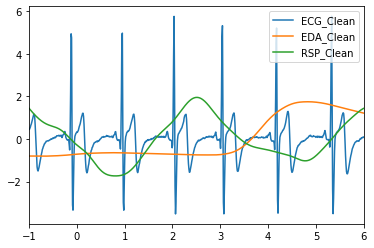

In [22]:
# Select the first epoch to plot
first_epoch = list(epochs.values())[0]
zscore_epoch = nk.standardize(first_epoch.loc[:,['ECG_Clean', 'EDA_Clean', 'RSP_Clean']])
zscore_epoch.plot()

## Extract Event Related Features

With this, we are able to compare how the physiological signals vary across the different events. We do this by iterating through the epochs and storing the results in a new dictionary which is converted into a dataframe, as shown below.



In [23]:
# Extract Event Related Features
df = {}  # Initialize an empty dict
for epoch_index in epochs:
    df[epoch_index] = {}  # Initialize an empty dict for the current epoch
    epoch = epochs[epoch_index]

    # ECG
    baseline = epoch["ECG_Rate"].loc[-100:0].mean()  # Baseline
    rr_max = epoch["ECG_Rate"].loc[0:400].max()  # Maximum RR interval
    df[epoch_index]["Heart_Rate_Variability"] = rr_max - baseline  # Corrected for baseline

    df[epoch_index]["Heart_Rate"] = epoch["ECG_Rate"].loc[0:600].mean()

    # EDA - SCR
    scr_max = epoch["SCR_Amplitude"].loc[0:600].max()  # Maximum SCR peak
    if np.isnan(scr_max):
        scr_max = 0  # If no SCR, consider the magnitude, i.e.  that the value is 0
    df[epoch_index]["SCR_Magnitude"] = scr_max

    # RSP
    df[epoch_index]["Breathing_Rate"] = epoch["RSP_Rate"].loc[0:600].mean()


df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df["Condition"] = condition_list  # Add the conditions
df  # Print DataFrame

,Heart_Rate_Variability,Heart_Rate,SCR_Magnitude,Breathing_Rate,Condition
1,-1.931320,55.729283,3.114808,18.409918,Negative
2,4.798275,61.389619,0.000000,16.575779,Neutral
3,7.557716,57.526045,0.000000,18.381962,Neutral
4,-0.545881,55.204032,1.675922,9.831068,Negative


## Plot Event Related Features


You can now plot and compare how these features differ according to the event of interest.

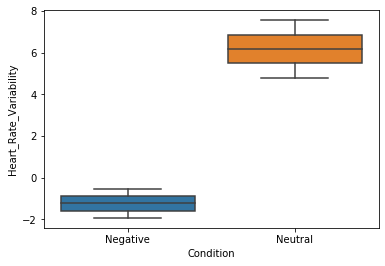

In [24]:
sns.boxplot(x="Condition", y="Heart_Rate_Variability", data=df)

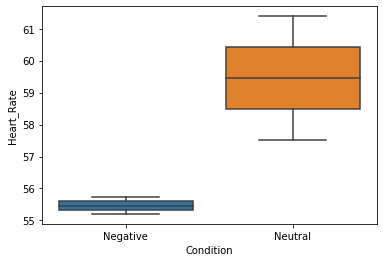

In [25]:
sns.boxplot(x="Condition", y="Heart_Rate", data=df)

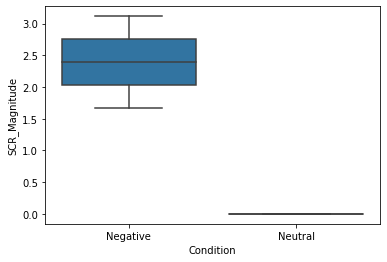

In [26]:
sns.boxplot(x="Condition", y="SCR_Magnitude", data=df)

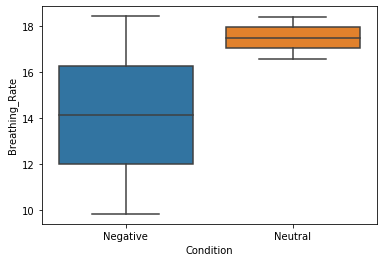

In [27]:
sns.boxplot(x="Condition", y="Breathing_Rate", data=df)